# Seasonal means

### Learning objectives

* import scientific data and manupulate using numpy
* understand the dimensionality of the data (space and time)
* use slicing to perform non-contiguous maths on the arrays (i.e. seasonal means)

### It might me helpful to know

* numpy arrays and slicing
* dictionaries


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xray
from netCDF4 import num2date
import netCDF4 as nc
import matplotlib.pyplot as plt


## Import Data

In [2]:
f = nc.Dataset('../data/example_data.nc')
print(f) 
print(f.variables.keys())

<type 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: /workspace/jhamman/processed/R1002RBRxaaa01a/lnd/temp/R1002RBRxaaa01a.vic.ha.1979-09-01.nc
    institution: U.W.
    source: RACM R1002RBRxaaa01a
    output_frequency: daily
    output_mode: averaged
    convention: CF-1.4
    references: Based on the initial model of Liang et al., 1994, JGR, 99, 14,415- 14,429.
    comment: Output from the Variable Infiltration Capacity (VIC) model.
    nco_openmp_thread_number: 1
    NCO: 4.3.7
    history: history deleted for brevity
    dimensions(sizes): time(36), y(205), x(275)
    variables(dimensions): float64 Tair(time,y,x), float64 time(time)
    groups: 

[u'Tair', u'time']


In [33]:
 # get netcdf data as Numpy
Tair = f.variables['Tair']# temperature variable
Time = f.variables['time'] #time variable

tair = Tair[:] 
time = Time[:]

## get datetime objects

In [11]:
times = nc.num2date(time, 'days since 0001-01-01', '365_day')
times

array([1980-09-16 12:00:00, 1980-10-17 00:00:00, 1980-11-16 12:00:00,
       1980-12-17 00:00:00, 1981-01-17 00:00:00, 1981-02-15 12:00:00,
       1981-03-17 00:00:00, 1981-04-16 12:00:00, 1981-05-17 00:00:00,
       1981-06-16 12:00:00, 1981-07-17 00:00:00, 1981-08-17 00:00:00,
       1981-09-16 12:00:00, 1981-10-17 00:00:00, 1981-11-16 12:00:00,
       1981-12-17 00:00:00, 1982-01-17 00:00:00, 1982-02-15 12:00:00,
       1982-03-17 00:00:00, 1982-04-16 12:00:00, 1982-05-17 00:00:00,
       1982-06-16 12:00:00, 1982-07-17 00:00:00, 1982-08-17 00:00:00,
       1982-09-16 12:00:00, 1982-10-17 00:00:00, 1982-11-16 12:00:00,
       1982-12-17 00:00:00, 1983-01-17 00:00:00, 1983-02-15 12:00:00,
       1983-03-17 00:00:00, 1983-04-16 12:00:00, 1983-05-17 00:00:00,
       1983-06-16 12:00:00, 1983-07-17 00:00:00, 1983-08-17 00:00:00], dtype=object)

In [38]:
print(type(times[0]))

<type 'netcdftime._datetime.datetime'>


In [18]:
seasons = np.split(times[::-1], 12)
seasons.reverse()
SON = seasons[::4]
DJF = seasons[1::4]
MAM = seasons[2::4]
JJA = seasons[3::4]

In [19]:
dseasons = np.split(tair[::-1, :, :], 12)
dSON = np.array(dseasons[::4])
dDJF = np.array(dseasons[1::4])
dMAM = np.array(dseasons[2::4])
dJJA = np.array(dseasons[3::4])

In [20]:
spring = dSON.mean(axis=(0,1))
summer = dDJF.mean(axis=(0,1))
autumn = dMAM.mean(axis=(0,1))
winter = dJJA.mean(axis=(0,1))

## Masking arrays

In [31]:
np.ma.masked_where(summer > 1e3, summer)

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., 21.381107111839547 21.34491997322489 21.6092135790324]
 [-- -- -- ..., 21.619054073972084 21.136305810911082 21.432466211397934]
 [-- -- -- ..., 21.32390395749044 21.018044519471633 21.17617163794933]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]],
       fill_value = 1e+20)

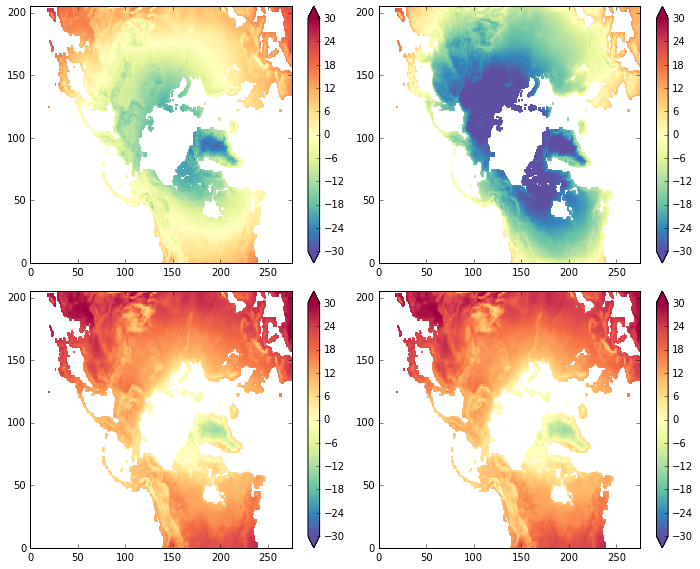

In [32]:
# plot with various axes scales
fig = plt.figure(figsize=(10,8))
is_null = np.isnan(summer)
# summer
ax1 = fig.add_subplot(221)
plt.pcolormesh(np.ma.masked_where(summer > 1e3, summer), vmin=-30, vmax=30, cmap='Spectral_r')
plt.colorbar(extend='both')
plt.tight_layout()
ax1.axes.axis('tight')

# autumn
ax2 = fig.add_subplot(222)
plt.pcolormesh(np.ma.masked_where(summer > 1e3, autumn), vmin=-30, vmax=30, cmap='Spectral_r')
plt.colorbar(extend='both')
ax2.axes.axis('tight')


# winter
ax3 = fig.add_subplot(223)
plt.pcolormesh(np.ma.masked_where(summer > 1e3, spring), vmin=-30, vmax=30, cmap='Spectral_r')
plt.colorbar(extend='both')
plt.tight_layout()
ax3.axes.axis('tight')

# spring
ax4 = fig.add_subplot(224)
plt.pcolormesh(np.ma.masked_where(summer > 1e3, spring), vmin=-30, vmax=30, cmap='Spectral_r')
plt.colorbar(extend='both')
plt.tight_layout()
ax4.axes.axis('tight')


plt.show()

## Helper functions for the weighted means

In [39]:
#Utility dictionary

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]} 

In [40]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm2(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)
    
    cal_days = dpm[calendar]
    
    for i, dt in enumerate(times):
        #print i, dt
        month_length[i] = cal_days[dt.month]
        if leap_year(dt.year, calendar=calendar):
            month_length[i] += 1
    return month_length



In [41]:
dayspermonth = get_dpm2(times, calendar='standard')
dayspermonth

array([31, 32, 31, 32, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31])